# SIG 

In [1]:
! pip install rasterio
! pip install earthpy

In [2]:
import rasterio as rio
import earthpy.plot as ep
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


## Cargamos el Raster Grosor sedimentario
---
Para esto utlizamos en paquete Rasterio y con numpy hacemos las correciones necesarias como quitar valores núlos y en el caso de las edades corregir los decimales de las edades para que queden en un rango global 0 - 280

In [3]:
#Cargamos el tiff de grosor sedimentarios de la cuenca Panamá
thickness_sed = rio.open('thickness_sed1.tif')

In [4]:
#miramos las cordenadas del raster cargado grosor sedimentario
thickness_sed.bounds

BoundingBox(left=-102.88206326184, bottom=-2.766261613718939, right=-76.632063261945, top=7.983738386238061)

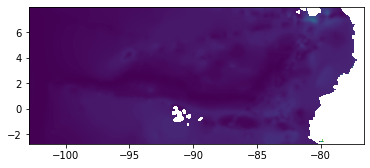

In [5]:
#también puede ser viasualizado con rasterio
from rasterio.plot import show
show(thickness_sed);


In [6]:
# Masked = True sets no data values to np.nan if they are in the metadata
thickness_sed_data = thickness_sed.read(1, masked=True) #convierte nuestro raster en un arreglo numpy
thickness_sed_meta = thickness_sed.profile
# EXPLORE: View summary statistics of canopy height model
# Notice the mean value with 0's included in the data
print('Mean:', np.nanmean(thickness_sed_data))
print('Max:', np.nanmax(thickness_sed_data))
print('Min:', np.nanmin(thickness_sed_data))

Mean: 232.97592
Max: 4627.339
Min: 0.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


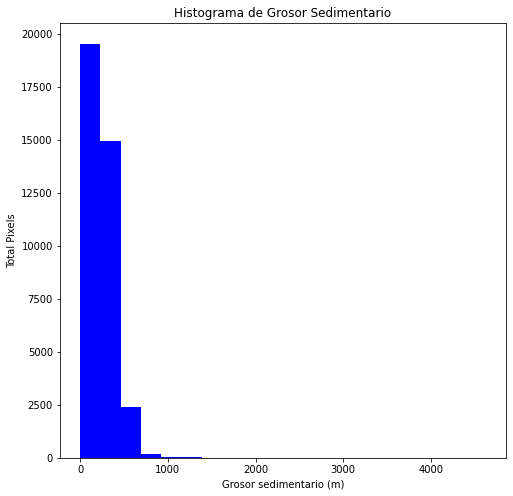

In [7]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(thickness_sed_data,
           figsize=(8,8), 
           colors="blue", 
           xlabel="Grosor sedimentario (m)", 
           ylabel="Total Pixels", 
           title="Histograma de Grosor Sedimentario");

In [8]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
thickness_sed_data[thickness_sed_data == 0] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(thickness_sed_data))
print('Max:', np.nanmax(thickness_sed_data))
print('Min:', np.nanmin(thickness_sed_data))

Mean: 233.00099
Max: 4627.339
Min: 7.730707e-12


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


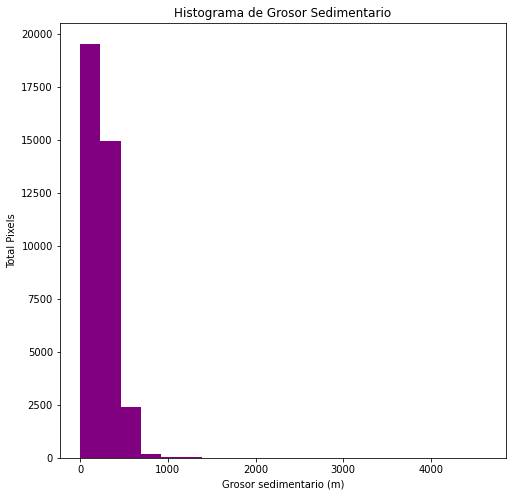

In [9]:
# Este histograma muestra los valores de px habiendo quitado los valores nulos
ax=ep.hist(thickness_sed_data,
           figsize=(8,8), 
           colors="purple", 
           xlabel="Grosor sedimentario (m)", 
           ylabel="Total Pixels", 
           title="Histograma de Grosor Sedimentario");

Sin embargo no se observa gran diferencia al remover los valores nulos entre el primer histograma (Azul) y el segundo (Purpura)

## Cargamos el Raster de Edad
---
Para esto utlizamos en paquete Rasterio

In [10]:
#Cargamos el tiff de edades de piso oceánico de la cuenca Panamá
Edad = rio.open('edad1.tif')

In [11]:
#miramos las cordenadas del raster cargado edades
Edad.bounds

BoundingBox(left=-102.88206326184, bottom=-2.766261613718939, right=-76.58206326184, top=8.033738386281062)

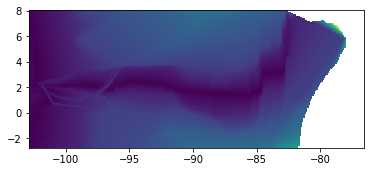

In [12]:
from rasterio.plot import show
show(Edad);

In [13]:
# Masked = True sets no data values to np.nan if they are in the metadata
Edad_data = Edad.read(1, masked=False) #convierte nuestro raster en un arreglo numpy
Edad_meta = Edad.profile
# EXPLORE: View summary statistics of canopy height model
# Notice the mean value with 0's included in the data
print('Mean:', np.nanmean(Edad_data))
print('Max:', np.nanmax(Edad_data))
print('Min:', np.nanmin(Edad_data))

Mean: -3490.327594704971
Max: 5209
Min: -32768


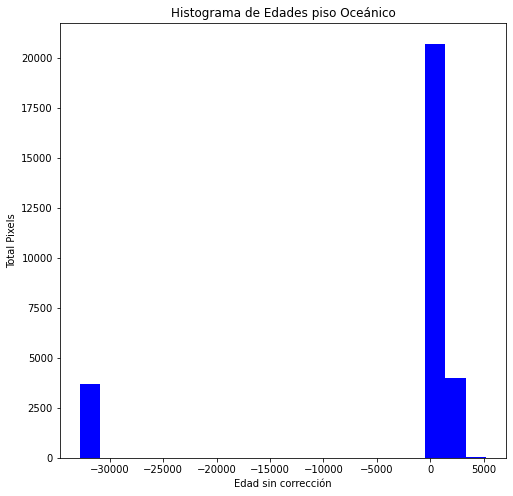

In [14]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(Edad_data,
           figsize=(8,8), 
           colors="blue", 
           xlabel="Edad sin corrección", 
           ylabel="Total Pixels", 
           title="Histograma de Edades piso Oceánico");

In [15]:
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
Edad_data[Edad_data< 0] = 0
Edad_data = Edad_data/100

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(Edad_data))
print('Max:', np.nanmax(Edad_data))
print('Min:', np.nanmin(Edad_data))

Mean: 7.493006266722997
Max: 52.09
Min: 0.0


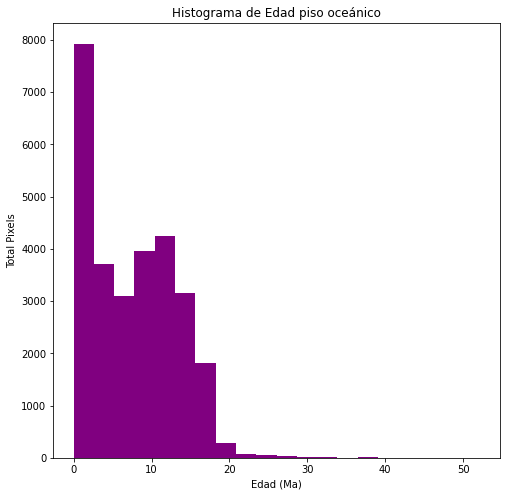

In [16]:
# Este histograma muestra los valores de px habiendo quitado los valores nulos
ax=ep.hist(Edad_data,
           figsize=(8,8), 
           colors="purple", 
           xlabel="Edad (Ma)", 
           ylabel="Total Pixels", 
           title="Histograma de Edad piso oceánico");

### Convirtiendo un Arreglo a Raster
---

Aquí lo que se hizo depues de un día entero de intentos fue:
Haivendo convertido los valores de edades de arreglo .read que estaban en un formato que se salía de los valores normales y quitando los valores negativos

Importar el arreglo modificado a un nuevo raster.tif

In [17]:
from rasterio.transform import from_origin

#################################
# MUY IMPORTANTE CAMBIAR LOS PARAMETRO IMPUESTO POR EL ARCHIVO PROFILE!!!!! 
#ME GASTE TODO UN DÍA ENCONTRANDO LA SOLUCIÓN!
Edad_meta['nodata']= 0
Edad_meta['dtype']= 'float64'
#################################

#sistema de referencia del raster
Sist_ref = Edad.crs
#tamaño de pixel en x & y del raster
pxsz, pysz = Edad.res
#bordes del raster
west, south, east, north = Edad.bounds

#.from_origin(esquina izq west, esquina supe north, xsize, ysize)
transform = from_origin(west, north, pxsz, pysz)

#height = Edad_data.shape[0], width = Edad_data.shape[1]
new_Edad = rio.open('new_Edad.tif', 'w', **Edad_meta)

new_Edad.write(Edad_data, 1)
# ES NECESARIO ESTE ÚLTIMO CODIGO PARA QUE SE PUEDA VISALIZAR EL RASTER
new_Edad.close()


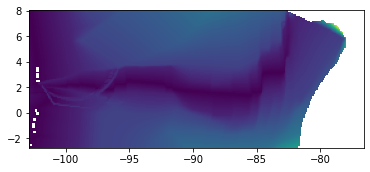

In [18]:
#Cargamos el tiff de nueva edad de la cuenca Panamá
new_Edad = rio.open('new_Edad.tif')

from rasterio.plot import show
show(new_Edad);

In [19]:
# Masked = True sets no data values to np.nan if they are in the metadata
Edad_data = new_Edad.read(1, masked=False) #convierte nuestro raster en un arreglo numpy
Edad_meta = new_Edad.profile

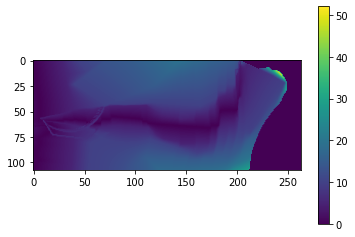

In [20]:
plt.imshow(Edad_data)
plt.colorbar()

## Cargamos los Puntos de flujo de calor
---
Para esto usamos geopandas

In [21]:
df_Flujo_calor = pd.read_csv('df_Flujo_calor1.csv', index_col= 0)
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314


In [22]:
#con este codigo se crea la columna geometry a partir de las columnas lon y lat de las coordenadas del df
Puntos_Flujo_calor = gpd.GeoDataFrame(df_Flujo_calor, geometry=gpd.points_from_xy(df_Flujo_calor.lon, df_Flujo_calor.lat))

#Verificamos que se haya creado la columna geometry
Puntos_Flujo_calor.head()


,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86670 3.53722)
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.95099)
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90680 2.72054)
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.01960 2.15099)
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05290 2.03431)


In [23]:
#verificamos que columna esta tomando como geometry
Puntos_Flujo_calor.geometry.name


'geometry'

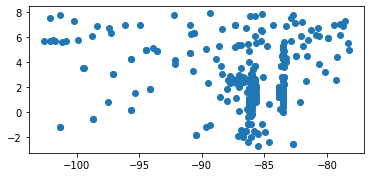

In [24]:
#ploteamos los puntos para visualizar el geodataframe
ax = Puntos_Flujo_calor.plot()

In [25]:
# Ensure this is a points layer as you think it is
Puntos_Flujo_calor.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

## Adicionamos grosor Sedimentario
---

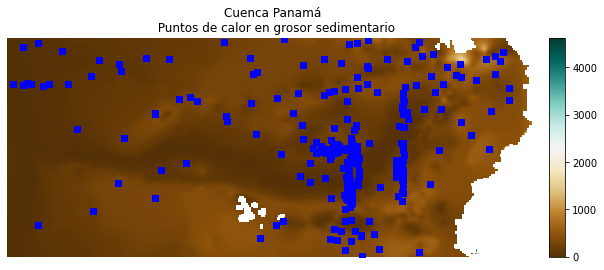

In [26]:
#miramos a que pixel en el reaster de grosores sedimentarios corresponde nuestro puntos de flujo de calor
from rasterio.plot import plotting_extent

fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(thickness_sed_data,
              extent=plotting_extent(thickness_sed), # Set spatial extent 
              cmap='BrBG',
              title="Cuenca Panamá \n Puntos de calor en grosor sedimentario",
              scale=False,
              ax=ax)

Puntos_Flujo_calor.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='blue')
ax.set_axis_off()
plt.show()

In [27]:
# Extraemos las coordenadas del Dataframe en una lista
coords = [(x,y) for x, y in zip(df_Flujo_calor.lon, df_Flujo_calor.lat)]

# Con este codigo muestramos los vaores de px en el raster y se lo agregamos al data frame
df_Flujo_calor['Sed_thickness (m)'] = [x for x in thickness_sed.sample(coords)]
df_Flujo_calor = df_Flujo_calor.astype({'Sed_thickness (m)': float})
df_Flujo_calor['Sed_thickness (m)'] = list(map(lambda x : round(x, 1), df_Flujo_calor['Sed_thickness (m)']))

df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m)
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86670 3.53722),279.0
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.95099),211.0
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90680 2.72054),203.0
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.01960 2.15099),159.0
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05290 2.03431),145.0


## Adicionamos Edad
---


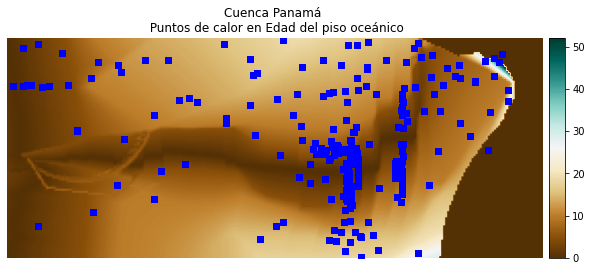

In [28]:
#miramos a que pixel en el reaster de grosores sedimentarios corresponde nuestro puntos de flujo de calor
from rasterio.plot import plotting_extent

fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(Edad_data,
              extent=plotting_extent(new_Edad), # Set spatial extent 
              cmap='BrBG',
              title="Cuenca Panamá \n Puntos de calor en Edad del piso oceánico",
              scale=False,
              ax=ax)

Puntos_Flujo_calor.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='blue')
ax.set_axis_off()
plt.show()

In [29]:
# Extraemos las coordenadas del Dataframe en una lista
coords = [(x,y) for x, y in zip(df_Flujo_calor.lon, df_Flujo_calor.lat)]

# Con este codigo muestramos los vaores de px en el raster y se lo agregamos al data frame
df_Flujo_calor['Age (Ma)'] = [x for x in new_Edad.sample(coords)]
df_Flujo_calor = df_Flujo_calor.astype({'Age (Ma)': float})
df_Flujo_calor['Age (Ma)'] = list(map(lambda x : round(x, 1), df_Flujo_calor['Age (Ma)']))

df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma)
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86670 3.53722),279.0,10.1
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.95099),211.0,7.6
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90680 2.72054),203.0,5.9
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.01960 2.15099),159.0,3.6
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05290 2.03431),145.0,3.1


In [30]:
#Sin embargo quedaron 3 edades en cero dado que algunos valores de flujo de calor se salían del raster de edades
zeros = df_Flujo_calor == 0
zeros.sum()

Codigo               0
lon                  0
lat                  0
Profundidad          0
Flujo_calor          0
Pesos                0
Flux_x_wts           0
geometry             0
Sed_thickness (m)    0
Age (Ma)             3
dtype: int64

In [31]:
df_Flujo_calor.shape

(1052, 10)

In [32]:
#Elimina las filas con valores iguales a cero en este caso elimina 3 filas
df_Flujo_calor = df_Flujo_calor[(df_Flujo_calor != 0).all(1)]
zeros = df_Flujo_calor == 0
zeros.sum()

Codigo               0
lon                  0
lat                  0
Profundidad          0
Flujo_calor          0
Pesos                0
Flux_x_wts           0
geometry             0
Sed_thickness (m)    0
Age (Ma)             0
dtype: int64

In [33]:
#filas eliminadas: 3
df_Flujo_calor.shape

(1049, 10)

In [34]:
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma)
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86670 3.53722),279.0,10.1
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.95099),211.0,7.6
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90680 2.72054),203.0,5.9
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.01960 2.15099),159.0,3.6
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05290 2.03431),145.0,3.1


In [35]:
from google.colab import files

df_Flujo_calor.to_csv('df_Flujo_calor2.csv')
files.download('df_Flujo_calor2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>